## Notebook 5

In this notebook I add additional features to my dataframe that help explain the variation in the price of BTC. Furthermore, multiple regression will control for these features with regards to their effect on BTC.

You will see below taht I replace a lot of the data I initially obtained via quandl has been replaced from a website called `blockchain.info`

In [38]:
from sklearn.model_selection import train_test_split
%run helper_functions.py
%run filters.py
%run plotly_functions.py
%run master_func.py
%run btc_info_df.py
plt.style.use('fivethirtyeight')
%autosave 120
import quandl
from datetime import date
from tabulate import tabulate
from collections import Counter
from IPython.display import Image
import math
import string
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['legend.fontsize'] = 20
plt.style.use('fivethirtyeight')
pd.set_option('display.max_colwidth', -1)
import plotly.plotly as py
import plotly.graph_objs as go
import spacy
nlp = spacy.load("en")
nltk_stopwords = stopwords.words("english")+["rt", "via","-»","--»","--","---","-->","<--","->","<-","«--","«","«-","»","«»", " →", "→"]
punc = '#!"%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

Autosaving every 120 seconds


In this notebook, I will get additional features from blockchain.info.

I came across blockchain.info that has a PLETHORA of data regarding bitcoin!

As such, I will be getting all my information from here.

In [2]:
modelling_df = unpickle_object("modelling_df_V1.pkl")
modelling_df.head()

,date,gold_price,eth_price,pos_sent,neg_sent,neu_sent,compound_sent,Open,High,Low,Close,Volume (Currency),Weighted Price
0,2016-10-26,1273.9,11.455,0.143706,0.066297,0.790006,0.115130,651.97,677.00,651.69,675.11,4.466380e+06,665.012877
1,2016-10-27,1269.3,11.515,0.127429,0.064310,0.808264,0.093255,674.63,685.89,665.59,684.71,3.090090e+06,679.822527
2,2016-10-28,1265.9,11.280,0.128794,0.056393,0.814586,0.104770,684.68,687.23,677.05,685.91,2.446578e+06,684.534409
3,2016-10-29,1265.9,10.770,0.139114,0.063177,0.797478,0.109344,685.91,717.99,684.89,711.13,2.839204e+06,703.664235
4,2016-10-30,1265.9,10.805,0.131922,0.064369,0.803709,0.093237,711.10,711.78,691.49,697.23,2.630803e+06,701.075287


The above dataframe represents where we started. I will be replacing volume and weighted price moving forward.

I will also be dropping open, high, low and close in addition to compound_sent which represents a univariate metric for sentiment, whereas I am convered with a multivariate metrics.

In [3]:
modelling_df.drop(["Close","High", "Low", "Open", "compound_sent", "Volume (Currency)", "Weighted Price"], axis=1, inplace=True)

In [4]:
modelling_df.head()

,date,gold_price,eth_price,pos_sent,neg_sent,neu_sent
0,2016-10-26,1273.9,11.455,0.143706,0.066297,0.790006
1,2016-10-27,1269.3,11.515,0.127429,0.064310,0.808264
2,2016-10-28,1265.9,11.280,0.128794,0.056393,0.814586
3,2016-10-29,1265.9,10.770,0.139114,0.063177,0.797478
4,2016-10-30,1265.9,10.805,0.131922,0.064369,0.803709


## Adding Total Number of confirmed transactions per day

In [5]:
tot_num_trans = pd.read_csv("/Users/ibrahimgabr/Downloads/project-5/Data/blockchain.info/total_num_trans_per_day_btc.csv", header=None)
subset_tot_num_trans = clean_blockchain_csv(tot_num_trans, ["date", "tot_num_trans"])
df1 = pd.merge(modelling_df, subset_tot_num_trans, on='date', how="outer")
df1.head()

,date,gold_price,eth_price,pos_sent,neg_sent,neu_sent,tot_num_trans
0,2016-10-26,1273.9,11.455,0.143706,0.066297,0.790006,225924.0
1,2016-10-27,1269.3,11.515,0.127429,0.064310,0.808264,326388.0
2,2016-10-28,1265.9,11.280,0.128794,0.056393,0.814586,250876.0
3,2016-10-29,1265.9,10.770,0.139114,0.063177,0.797478,229689.0
4,2016-10-30,1265.9,10.805,0.131922,0.064369,0.803709,209337.0


## Adding No. of Unique BTC Addresses BTC

In [6]:
num_unique_addr = pd.read_csv("/Users/ibrahimgabr/Downloads/project-5/Data/blockchain.info/unique_address_btc.csv", header=None)
subset_num_unique_addr = clean_blockchain_csv(num_unique_addr, ['date', "unique_addr"])
df2 = pd.merge(df1, subset_num_unique_addr, on='date', how="outer")
df2.head()

,date,gold_price,eth_price,pos_sent,neg_sent,neu_sent,tot_num_trans,unique_addr
0,2016-10-26,1273.9,11.455,0.143706,0.066297,0.790006,225924.0,431781.0
1,2016-10-27,1269.3,11.515,0.127429,0.064310,0.808264,326388.0,457806.0
2,2016-10-28,1265.9,11.280,0.128794,0.056393,0.814586,250876.0,434269.0
3,2016-10-29,1265.9,10.770,0.139114,0.063177,0.797478,229689.0,416457.0
4,2016-10-30,1265.9,10.805,0.131922,0.064369,0.803709,209337.0,360327.0


## Adding Market Cap

In [7]:
mkt_cap = pd.read_csv("/Users/ibrahimgabr/Downloads/project-5/Data/blockchain.info/market_cap_btc.csv", header=None)
subset_mkt_cap = clean_blockchain_csv(mkt_cap, ['date', "mkt_cap"])
df3 = pd.merge(df2, subset_mkt_cap, on='date', how="outer")
df3.head()

,date,gold_price,eth_price,pos_sent,neg_sent,neu_sent,tot_num_trans,unique_addr,mkt_cap
0,2016-10-26,1273.9,11.455,0.143706,0.066297,0.790006,225924.0,431781.0,1.075119e+10
1,2016-10-27,1269.3,11.515,0.127429,0.064310,0.808264,326388.0,457806.0,1.093394e+10
2,2016-10-28,1265.9,11.280,0.128794,0.056393,0.814586,250876.0,434269.0,1.101645e+10
3,2016-10-29,1265.9,10.770,0.139114,0.063177,0.797478,229689.0,416457.0,1.143388e+10
4,2016-10-30,1265.9,10.805,0.131922,0.064369,0.803709,209337.0,360327.0,1.123223e+10


## Adding hash rate

In [8]:
hash_rate = pd.read_csv("/Users/ibrahimgabr/Downloads/project-5/Data/blockchain.info/hash_rate_btc.csv", header=None)
subset_hash_rate = clean_blockchain_csv(hash_rate, ['date', "hash_rate"])
df4 = pd.merge(df3, subset_hash_rate, on='date', how="outer")
df4.head()

,date,gold_price,eth_price,pos_sent,neg_sent,neu_sent,tot_num_trans,unique_addr,mkt_cap,hash_rate
0,2016-10-26,1273.9,11.455,0.143706,0.066297,0.790006,225924.0,431781.0,1.075119e+10,1.752433e+06
1,2016-10-27,1269.3,11.515,0.127429,0.064310,0.808264,326388.0,457806.0,1.093394e+10,2.042404e+06
2,2016-10-28,1265.9,11.280,0.128794,0.056393,0.814586,250876.0,434269.0,1.101645e+10,1.916330e+06
3,2016-10-29,1265.9,10.770,0.139114,0.063177,0.797478,229689.0,416457.0,1.143388e+10,1.878507e+06
4,2016-10-30,1265.9,10.805,0.131922,0.064369,0.803709,209337.0,360327.0,1.123223e+10,2.130656e+06


## Adding mempool transaction count

In [9]:
mempool_trans = pd.read_csv("/Users/ibrahimgabr/Downloads/project-5/Data/blockchain.info/mempool_trans_count_btc.csv", header=None)
subset_mempool_trans = clean_blockchain_csv(mempool_trans, ['date', "mempool_trans"])
subset_mempool_trans['date'] = subset_mempool_trans['date'].apply(lambda x: x.date())
subset_mempool_trans = subset_mempool_trans.groupby("date").sum().reset_index()
del subset_mempool_trans['date']
df5 = pd.concat([df4, subset_mempool_trans], axis=1) #couldnt merge for some reason
df5.head()

,date,gold_price,eth_price,pos_sent,neg_sent,neu_sent,tot_num_trans,unique_addr,mkt_cap,hash_rate,mempool_trans
0,2016-10-26,1273.9,11.455,0.143706,0.066297,0.790006,225924.0,431781.0,1.075119e+10,1.752433e+06,69811.000000
1,2016-10-27,1269.3,11.515,0.127429,0.064310,0.808264,326388.0,457806.0,1.093394e+10,2.042404e+06,171358.250000
2,2016-10-28,1265.9,11.280,0.128794,0.056393,0.814586,250876.0,434269.0,1.101645e+10,1.916330e+06,131888.333333
3,2016-10-29,1265.9,10.770,0.139114,0.063177,0.797478,229689.0,416457.0,1.143388e+10,1.878507e+06,17765.750000
4,2016-10-30,1265.9,10.805,0.131922,0.064369,0.803709,209337.0,360327.0,1.123223e+10,2.130656e+06,20822.250000


## adding estiamted USD transaction value

In [10]:
est_USD_tans_val = pd.read_csv("/Users/ibrahimgabr/Downloads/project-5/Data/blockchain.info/estimated-transaction-volume-usd.csv", header=None)
subset_est_USD_tans_val = clean_blockchain_csv(est_USD_tans_val, ['date', "USD_trans_val"])
df6 = pd.merge(df5, subset_est_USD_tans_val, on='date', how="outer")
df6.head()


,date,gold_price,eth_price,pos_sent,neg_sent,neu_sent,tot_num_trans,unique_addr,mkt_cap,hash_rate,mempool_trans,USD_trans_val
0,2016-10-26,1273.9,11.455,0.143706,0.066297,0.790006,225924.0,431781.0,1.075119e+10,1.752433e+06,69811.000000,1.768021e+08
1,2016-10-27,1269.3,11.515,0.127429,0.064310,0.808264,326388.0,457806.0,1.093394e+10,2.042404e+06,171358.250000,2.832341e+08
2,2016-10-28,1265.9,11.280,0.128794,0.056393,0.814586,250876.0,434269.0,1.101645e+10,1.916330e+06,131888.333333,1.946002e+08
3,2016-10-29,1265.9,10.770,0.139114,0.063177,0.797478,229689.0,416457.0,1.143388e+10,1.878507e+06,17765.750000,1.674801e+08
4,2016-10-30,1265.9,10.805,0.131922,0.064369,0.803709,209337.0,360327.0,1.123223e+10,2.130656e+06,20822.250000,1.797445e+08


## Adding Average market price across all exchanges.

In [60]:
mkt_price = pd.read_csv("/Users/ibrahimgabr/Downloads/project-5/Data/blockchain.info/market_price_btc.csv", header=None)
subset_mkt_price = clean_blockchain_csv(mkt_price, ['date', "mkt_price"])
df7 = pd.merge(df6, subset_mkt_price, on="date", how="outer")
df7.head()

,date,gold_price,eth_price,pos_sent,neg_sent,neu_sent,tot_num_trans,unique_addr,mkt_cap,hash_rate,mempool_trans,USD_trans_val,mkt_price
0,2016-10-26,1273.9,11.455,0.143706,0.066297,0.790006,225924.0,431781.0,1.075119e+10,1.752433e+06,69811.000000,1.768021e+08,672.221413
1,2016-10-27,1269.3,11.515,0.127429,0.064310,0.808264,326388.0,457806.0,1.093394e+10,2.042404e+06,171358.250000,2.832341e+08,682.223962
2,2016-10-28,1265.9,11.280,0.128794,0.056393,0.814586,250876.0,434269.0,1.101645e+10,1.916330e+06,131888.333333,1.946002e+08,687.688337
3,2016-10-29,1265.9,10.770,0.139114,0.063177,0.797478,229689.0,416457.0,1.143388e+10,1.878507e+06,17765.750000,1.674801e+08,714.895450
4,2016-10-30,1265.9,10.805,0.131922,0.064369,0.803709,209337.0,360327.0,1.123223e+10,2.130656e+06,20822.250000,1.797445e+08,698.003400


In [62]:
dates_lst = df7['date']
df7.head()

,date,gold_price,eth_price,pos_sent,neg_sent,neu_sent,tot_num_trans,unique_addr,mkt_cap,hash_rate,mempool_trans,USD_trans_val,mkt_price
0,2016-10-26,1273.9,11.455,0.143706,0.066297,0.790006,225924.0,431781.0,1.075119e+10,1.752433e+06,69811.000000,1.768021e+08,672.221413
1,2016-10-27,1269.3,11.515,0.127429,0.064310,0.808264,326388.0,457806.0,1.093394e+10,2.042404e+06,171358.250000,2.832341e+08,682.223962
2,2016-10-28,1265.9,11.280,0.128794,0.056393,0.814586,250876.0,434269.0,1.101645e+10,1.916330e+06,131888.333333,1.946002e+08,687.688337
3,2016-10-29,1265.9,10.770,0.139114,0.063177,0.797478,229689.0,416457.0,1.143388e+10,1.878507e+06,17765.750000,1.674801e+08,714.895450
4,2016-10-30,1265.9,10.805,0.131922,0.064369,0.803709,209337.0,360327.0,1.123223e+10,2.130656e+06,20822.250000,1.797445e+08,698.003400


In [14]:
df7.drop(["date"],axis=1, inplace=True)
features = "+".join(df7.columns[:-1])
y, X = dmatrices('mkt_price ~ ' + features, df7, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1) #looks like we are doing great!

,VIF Factor,features
0,0.0,Intercept
1,6.2,gold_price
2,7.3,eth_price
3,2929.5,pos_sent
4,2740.0,neg_sent
5,3809.8,neu_sent
6,9.3,tot_num_trans
7,6.7,unique_addr
8,4.9,mkt_cap
9,3.8,hash_rate


In [15]:
df7.corr()

,gold_price,eth_price,pos_sent,neg_sent,neu_sent,tot_num_trans,unique_addr,mkt_cap,hash_rate,mempool_trans,USD_trans_val,mkt_price
gold_price,1.000000,0.757126,-0.144099,-0.253473,0.345869,-0.145614,-0.179554,-0.190838,-0.078998,0.087767,-0.262199,-0.192922
eth_price,0.757126,1.000000,-0.164950,-0.116261,0.246974,0.054744,0.015746,0.356701,0.424836,0.272740,-0.057522,0.354780
pos_sent,-0.144099,-0.164950,1.000000,-0.331122,-0.596950,-0.364671,-0.314049,0.095966,-0.046629,-0.110460,-0.251987,0.095882
neg_sent,-0.253473,-0.116261,-0.331122,1.000000,-0.559188,0.232886,0.186956,0.059911,0.159483,0.316399,0.226054,0.062722
neu_sent,0.345869,0.246974,-0.596950,-0.559188,1.000000,0.121603,0.115460,-0.136225,-0.095277,-0.172732,0.028343,-0.138543
tot_num_trans,-0.145614,0.054744,-0.364671,0.232886,0.121603,1.000000,0.912685,0.255176,0.300830,0.405603,0.640318,0.256059
unique_addr,-0.179554,0.015746,-0.314049,0.186956,0.115460,0.912685,1.000000,0.277024,0.303917,0.313126,0.549696,0.278896
mkt_cap,-0.190838,0.356701,0.095966,0.059911,-0.136225,0.255176,0.277024,1.000000,0.782959,0.247076,0.339656,0.999808
hash_rate,-0.078998,0.424836,-0.046629,0.159483,-0.095277,0.300830,0.303917,0.782959,1.000000,0.289567,0.131122,0.784233
mempool_trans,0.087767,0.272740,-0.110460,0.316399,-0.172732,0.405603,0.313126,0.247076,0.289567,1.000000,0.158235,0.249801


We can see from above that mkt_price and mkt_cap are perfectly collinear. We will drop mkt_cap. We will also drop neu_sent as it has an extremely large VIF.

In [16]:
df7.drop(["neu_sent", "mkt_cap"],axis=1, inplace=True)
features = "+".join(df7.columns[:-1])
y, X = dmatrices('mkt_price ~ ' + features, df7, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1) #looks like we are doing great!

,VIF Factor,features
0,4001.1,Intercept
1,5.0,gold_price
2,5.7,eth_price
3,1.4,pos_sent
4,1.5,neg_sent
5,8.5,tot_num_trans
6,6.4,unique_addr
7,2.5,hash_rate
8,1.5,mempool_trans
9,2.0,USD_trans_val


In [17]:
df7.corr()

,gold_price,eth_price,pos_sent,neg_sent,tot_num_trans,unique_addr,hash_rate,mempool_trans,USD_trans_val,mkt_price
gold_price,1.000000,0.757126,-0.144099,-0.253473,-0.145614,-0.179554,-0.078998,0.087767,-0.262199,-0.192922
eth_price,0.757126,1.000000,-0.164950,-0.116261,0.054744,0.015746,0.424836,0.272740,-0.057522,0.354780
pos_sent,-0.144099,-0.164950,1.000000,-0.331122,-0.364671,-0.314049,-0.046629,-0.110460,-0.251987,0.095882
neg_sent,-0.253473,-0.116261,-0.331122,1.000000,0.232886,0.186956,0.159483,0.316399,0.226054,0.062722
tot_num_trans,-0.145614,0.054744,-0.364671,0.232886,1.000000,0.912685,0.300830,0.405603,0.640318,0.256059
unique_addr,-0.179554,0.015746,-0.314049,0.186956,0.912685,1.000000,0.303917,0.313126,0.549696,0.278896
hash_rate,-0.078998,0.424836,-0.046629,0.159483,0.300830,0.303917,1.000000,0.289567,0.131122,0.784233
mempool_trans,0.087767,0.272740,-0.110460,0.316399,0.405603,0.313126,0.289567,1.000000,0.158235,0.249801
USD_trans_val,-0.262199,-0.057522,-0.251987,0.226054,0.640318,0.549696,0.131122,0.158235,1.000000,0.337714
mkt_price,-0.192922,0.354780,0.095882,0.062722,0.256059,0.278896,0.784233,0.249801,0.337714,1.000000


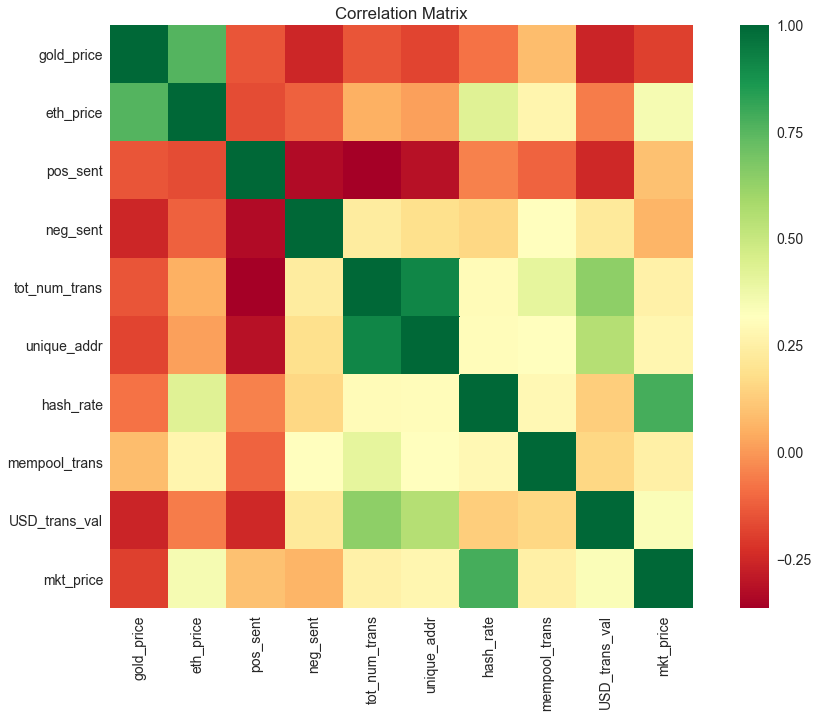

In [18]:
plot_corr_matrix(df7)

In [19]:
df7.head()

,gold_price,eth_price,pos_sent,neg_sent,tot_num_trans,unique_addr,hash_rate,mempool_trans,USD_trans_val,mkt_price
0,1273.9,11.455,0.143706,0.066297,225924.0,431781.0,1.752433e+06,69811.000000,1.768021e+08,672.221413
1,1269.3,11.515,0.127429,0.064310,326388.0,457806.0,2.042404e+06,171358.250000,2.832341e+08,682.223962
2,1265.9,11.280,0.128794,0.056393,250876.0,434269.0,1.916330e+06,131888.333333,1.946002e+08,687.688337
3,1265.9,10.770,0.139114,0.063177,229689.0,416457.0,1.878507e+06,17765.750000,1.674801e+08,714.895450
4,1265.9,10.805,0.131922,0.064369,209337.0,360327.0,2.130656e+06,20822.250000,1.797445e+08,698.003400


In [21]:
df7.shape

(120, 10)

In [33]:
# pickle_object(df7, "blockchain_info_df")

In [34]:
data = unpickle_object("blockchain_info_df.pkl")

In [63]:
data['date'] = dates_lst

In [64]:
percentage_missing(data)

In [66]:
data.set_index('date', inplace=True)
data.head()

,gold_price,eth_price,pos_sent,neg_sent,tot_num_trans,unique_addr,hash_rate,mempool_trans,USD_trans_val,mkt_price
date,,,,,,,,,,
2016-10-26,1273.9,11.455,0.143706,0.066297,225924.0,431781.0,1.752433e+06,69811.000000,1.768021e+08,672.221413
2016-10-27,1269.3,11.515,0.127429,0.064310,326388.0,457806.0,2.042404e+06,171358.250000,2.832341e+08,682.223962
2016-10-28,1265.9,11.280,0.128794,0.056393,250876.0,434269.0,1.916330e+06,131888.333333,1.946002e+08,687.688337
2016-10-29,1265.9,10.770,0.139114,0.063177,229689.0,416457.0,1.878507e+06,17765.750000,1.674801e+08,714.895450
2016-10-30,1265.9,10.805,0.131922,0.064369,209337.0,360327.0,2.130656e+06,20822.250000,1.797445e+08,698.003400
